# Autoregression with online FORCE learning

Let's see how we can perform time series prediction using an autoregressive ESN. The ESN will use feedback of its own output, and learn with two different learning rules:

1. The simple delta learning rule (provided).
2. The RLS (recursive least squares) learning rule (to be implemented).

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 4.8 (4.8.1) on darwin (posix).


We use the same standard neuron as before, but using a constant bias that can be different for all neurons of a population.

In [3]:
ESN_Neuron = ann.Neuron(
    parameters = """
        tau = 30.0     : population   # Time constant
        g = 1.0        : population   # Scaling
        bias = 0.0                    # Bias
    """,
    equations="""
        tau * dx/dt + x = sum(in) + g * sum(exc) + bias
        r = tanh(x)
    """
)

The following class implements the ESN with feedback. The construction is not very different from the previous exercise, except that the input population is now the feedback population. The reservoir neurons have a bias uniformly sampled between -1 and 1 (it helps the dynamics when no input is present). The readout weight vector and neuron are explicitly defined as numpy arrays.

The `step()` method has to be called at each step of the simulation. It first sets the activity of the input/feedback neuron to the previous readout activity. It then calls `ann.step()` to update activity in the reservoir. Finally, the readout activity is computed using a standard matrix-vector multiplication in numpy.

The `train()` method can be called to train the `Wout` matrix using the standard delta learning rule. It requires an outer product between the error vector $t-y$ and the input features `reservoir.r`. Note that it is not even necessary, as there is only one output neuron.

**Q:** Read and understand the code.

In [4]:
class ESN_DeltaLearning:
    """
    Echo-state network with feedback and the delta learning rule.
    """
    def __init__(self, N:int, g:float, tau:float, eta:float):
        """
        Args:
            N : number of neurons in the reservoir.
            g: spectral radius of the reservoir.
            tau: time constant.
            eta: learning rate.
        """
        self.N = N
        self.g = g
        self.tau = tau
        self.eta = eta

        # Clear ANNarchy, otherwise compile() cannot be called multiple times
        ann.clear()

        # Readout population
        self.inp = ann.Population(1, ann.Neuron(parameters="r=0.0"))

        # Recurrent population
        self.reservoir = ann.Population(N, ESN_Neuron)
        self.reservoir.g = g
        self.reservoir.tau = tau
        self.reservoir.bias = np.random.uniform(-1., 1., self.N)

        # Feedback weights
        self.Wi = ann.Projection(self.inp, self.reservoir, 'in')
        self.Wi.connect_all_to_all(weights=ann.Normal(0.0, 1.0))

        # Recurrent weights
        self.Wrec = ann.Projection(self.reservoir, self.reservoir, 'exc')
        self.Wrec.connect_all_to_all(weights=ann.Normal(0., 1/np.sqrt(N)))

        # Readout weights
        self.Wout = np.zeros((1, self.N))
        self.z = np.zeros(1)

        # Monitor
        self.monitor = ann.Monitor(self.reservoir, 'r')

        ann.compile()

    def step(self):
        "Performs one step of the simulation."

        # Set the previous readout output as the new input
        self.inp.r = self.z

        # Update the reservoir
        ann.step()

        # Compute the readout
        self.z = self.Wout @ self.reservoir.r

    def train(self, target:float):
        """
        Trains the readout weights with the delta learning rule.

        Args:
            target: desired output.
        """
        self.Wout += self.eta * np.outer(target - self.z, self.reservoir.r)


We will train the ESN to perform autoregression on a simple sine curve. The "training data" is a time series with 1000 points:

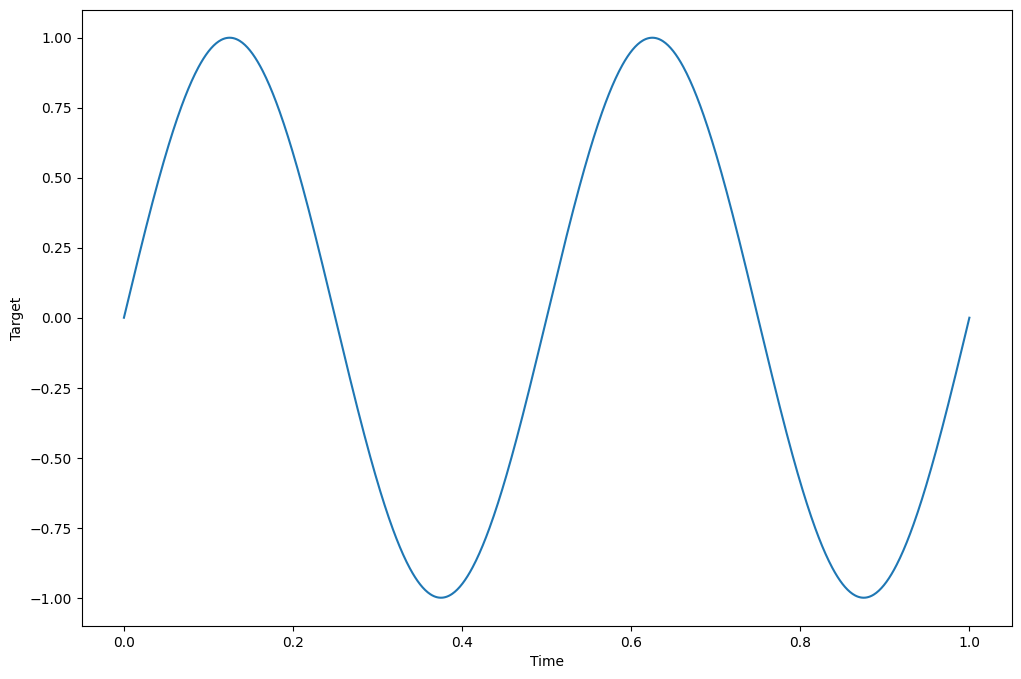

In [5]:
duration = 1000 # 1000 steps = one second

t = np.linspace(0, 1, duration) # time axis
X = np.sin(2*np.pi*t*2.) # Simple sine function

plt.figure(figsize=(12, 8))
plt.plot(t, X)
plt.xlabel("Time")
plt.ylabel("Target")
plt.show()

Let's create the ESN with some default parameters.

In [6]:
net = ESN_DeltaLearning(N=200, g=1.0, tau=30.0, eta=0.01)

Compiling ...  OK 


**Q:** Run the ESN autoregressively by calling the `step()` function 1000 times, but **not** calling `train()`. Visualize the activity of the reservoir and the readout. Conclude on what happens.

**Q:** Now alternate `step()` and `train()`, using each element of `X` as a target for `train()`. What happens?

**Q:** Continue running the simulation without training, only the autoregression. What happens? Why?

## FORCE learning with RLS

For the RLS learning rule applied to the readout weights $Wout$ ($N$ inputs, one output), we need to maintain a $N\times N$ matrix $P$ for the inverse of the information matrix.

P should be initialized to the identity matrix, with the elements being initially $1/\text{delta}$. `delta` plays the role of a learning rate. You can take `1e-2` as a value, but feel free to change it.

At each step of the algorithm, the input is the vector `r` (N elements) and the target value is `t`. The output of the readout neuron is `z = Wout @ r`.

You will need to update the matrix `P`and the weight vector `Wout` using these formulas:

$$
    \Delta P = - \dfrac{(P \times r) \times (P \times r)^T}{1 + r^T \times P \times r}
$$

$$
    \Delta \text{Wout} = \eta \, (t - z) \times \dfrac{P \times r}{1 + r^T \times P \times r} 
$$

It appears smart to precompute $P \times r$ and $1 + r^T \times P \times r$ because they appear in both equations.

**Q:** Create a new class `ESN_FORCE` based on `ESN_DeltaLearning` (copy and paste or inheritance) that modifies the `train()` method to use RLS instead of the delta learning rule. Print the shape of everything at the beginning to make sure you implement the right operation. Think of `@` for matrix multiplications.

**Q:** Train it on the sine function. Does it work now? Experiment with different values of `delta`, the size of the reservoir, etc. 

## Mackey-Glass chaotic time series

Let's now apply our ESN with FORCE to a time series less boring that the sine function. A standard benchmark for time series is the Mackey-Glass time series, which is an example of simple 1D chaotic time series. 

The Mackey-Glass equations are delayed differential equations that exhibit chaotic behavior, i.e. they cannot be predict accurately for a long period of time.

$$\frac{d x(t)}{dt} = \beta \, \frac{x(t - \tau)}{1 + x(t - \tau)^n} - \gamma \, x(t)$$

To check this, we use `reservoirpy` (<https://reservoirpy.readthedocs.io>) to generate two time series with very close initial conditions ($\epsilon = 10^{-6}$). After roughly two seconds of simulation, the two time series start to diverge.

In [19]:
#!pip install reservoirpy

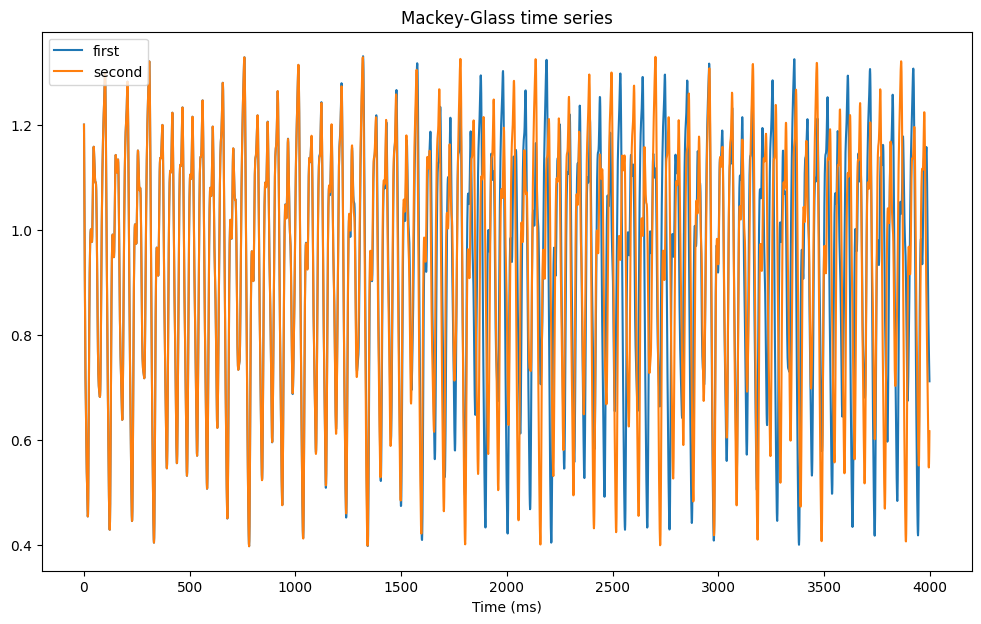

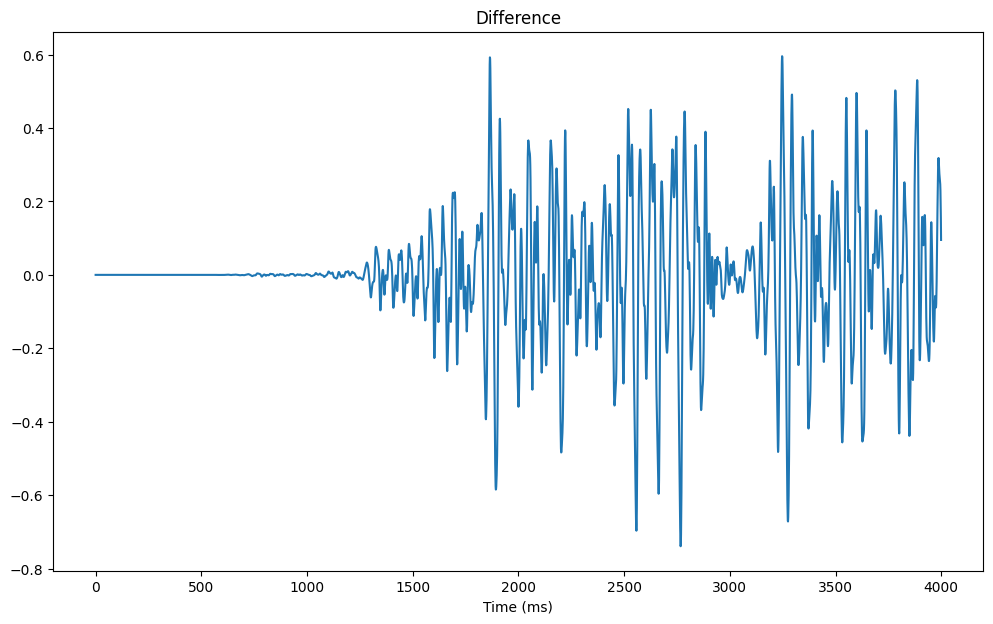

In [20]:
from reservoirpy.datasets import mackey_glass

mg1 = mackey_glass(4000, x0=1.2)
mg2 = mackey_glass(4000, x0=1.2 + 1e-6)

plt.figure(figsize=(12, 7))
plt.plot(mg1, label="first")
plt.plot(mg2, label="second")
plt.legend()
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(mg1 - mg2, label="difference")
plt.xlabel("Time (ms)")
plt.title("Difference")
plt.show()

Let's generate a time series for 2 seconds and normalize it between -1 and 1. This will be the training data for our ESN.

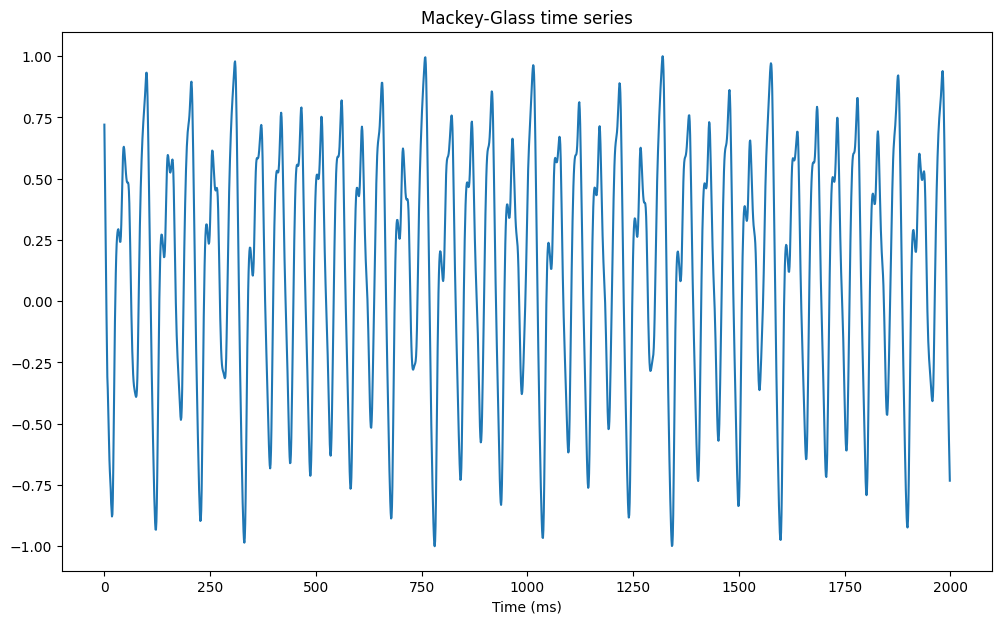

In [21]:
# Generate time series
mg = mackey_glass(2000, x0=1.2)

# Normalize between -1 and 1
mg =  2.0 * (mg - mg.min()) / (mg.max() - mg.min()) - 1.0

plt.figure(figsize=(12, 7))
plt.plot(mg)
plt.xlabel("Time (ms)")
plt.title("Mackey-Glass time series")
plt.show()

**Q:** Train the ESN+FORCE on the first 500 steps of Mackey-Glass time series, and test it on the rest. You may have to search for the right hyperparameters: g quite high, tau quite small (mg varies quite fast, so reduce the time constant of the reservoir a lot), delta very small (1e-5 or so).

**Q:** What do you think of the performance? If ou are not impressed, go read <https://www.sciencedirect.com/science/article/pii/S2666827022000275> to see how LSTMs perform on the same task.